In [1]:
import sys, os
sys.path.insert(0, os.path.abspath("../pyCudaPolygon"))
import pyCudaPolygon as pcp
import numpy as np
from matplotlib import pyplot as plt

In [2]:
n = 10
m = pcp.model(size = n)
m.setModelEnum("normal")
l = np.ones(n)

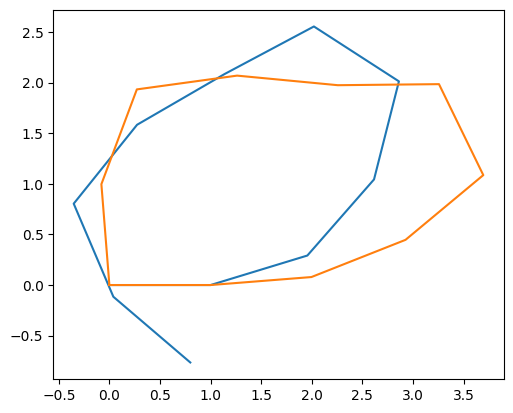

In [4]:
theta0, theta = m.generateRandomPolygon(l, 4, numSteps = 200)
(vx, vy) = m.getVertices(theta0, l).T
plt.plot(vx, vy)
(vx, vy) = m.getVertices(theta, l).T
plt.plot(vx, vy)
plt.gca().set_aspect(1)
plt.show()